In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import special
import mpmath as mp
import time
%matplotlib inline

In [3]:
import classy
from classy import Class

In [4]:
LambdaCDM = Class()
LambdaCDM.set({'omega_b':0.022383,'omega_cdm':0.12011,'h':0.6732,'ln10^{10}A_s':3.0448,'n_s':0.96605,'tau_reio':0.0543})

# run class
LambdaCDM.compute()
bg = LambdaCDM.get_background()
H_data = bg['H [1/Mpc]']/LambdaCDM.h() #Hubble factor in units of h/Mpc
z_data = bg['z'] #redshift, off course
comoving_distance_data = bg['comov. dist.']*1000#*LambdaCDM.h() #comoving distance in units of Mpc/h

#now we spline them
from scipy.interpolate import CubicSpline
a_data = 1./(1. + z_data)
Hubble = CubicSpline(a_data , H_data)
comoving_distance = CubicSpline(a_data, comoving_distance_data)

In [5]:
def D_angular(z_i):
    a_i = 1/(1 + z_i)
    return a_i*comoving_distance(a_i)
def D_sl(z_s, z_l):
    a_s = 1/(1 + z_s)
    a_l = 1/(1 + z_l)
    return a_l*(comoving_distance(a_s) - comoving_distance(a_l))

In [6]:
def density(theta, theta_0):
    sigma = 0.3
    return np.exp(-0.5*np.sum((theta - theta_0[:, None, None]*np.ones_like(theta))**2/sigma**2, 0))/(2*np.pi*sigma**2)

In [7]:
from ezigzag import parse_args
from ezigzag.data import HDF5Dataset, TrainTestDataLoader

ds = HDF5Dataset("./data", meta_groups="**/metadata/*", collate=True)
dl = TrainTestDataLoader(ds, ds, batch_size=1, shuffle=False)

for i, batch in dl.tqdm():
      info = batch[1]  # dictionary with metadata like extent, units, etc.
      if i == 0:
            break
      ...

  0%|          | 0/4000 [00:00<?, ?it/s]


In [8]:
from ezigzag import parse_args
from ezigzag.data import HDF5Dataset, TrainTestDataLoader

ds = HDF5Dataset("./data", meta_groups="**/metadata/*", collate=True)
dl = TrainTestDataLoader(ds, ds, batch_size=1, shuffle=False)

for i, batch in dl.tqdm():
      info[i] = batch[1]  # dictionary with metadata like extent, units, etc.
      if i == 4000:
            break
      ...

100%|██████████| 4000/4000 [00:19<00:00, 202.81it/s]


In [9]:
import h5py
data = h5py.File('data/240818_tng50-1_dm_99_gids.1000.2000.hdf5', 'r')

galaxies_data = data['dm']['metadata']
galaxies = data['dm']['images']

N = np.size(galaxies[0, 0, :])
N_min = int(N*0.5 - 50)
N_max = int(N*0.5 + 50)

galaxies = galaxies[:, N_min:N_max, N_min:N_max]

In [10]:
X = np.zeros([4000, N])
X.shape

(4000, 512)

In [11]:
for i in range(0, 4000):
    X[i, :] = np.linspace(info[i]['extent'][0][0], info[i]['extent'][0][1], N)

X = X[:, N_min:N_max]

In [12]:
galaxies.shape

(4000, 100, 100)

In [13]:
#It takes the array on which the bidimensional density is computed, and the bidimensional density itself
def newtonian_potential_grid(theta_grid, Sigma):
    dtheta = theta_grid[1] - theta_grid[0]
    eps = 0.0001*dtheta #softening length
    integrand = Sigma[:, :, None, None]*np.log(np.sqrt((theta_grid[:, None, None, None] - theta_grid[None, None, :, None])**2 + (theta_grid[None, :, None, None] - theta_grid[None, None, None, :])**2 + eps**2) )
    result = np.sum(integrand, axis = (0, 1))
    return dtheta*dtheta*(result - np.ones_like(result)*result[0, 0])

In [14]:
GM = 4.302*1e-6 #in kpc (km/s)^2
c_light = 2.99792*1e+5 #in km/s

GM_c2 = GM/(c_light*c_light)
GM_c2 #(in kpc)

4.78663516644209e-17

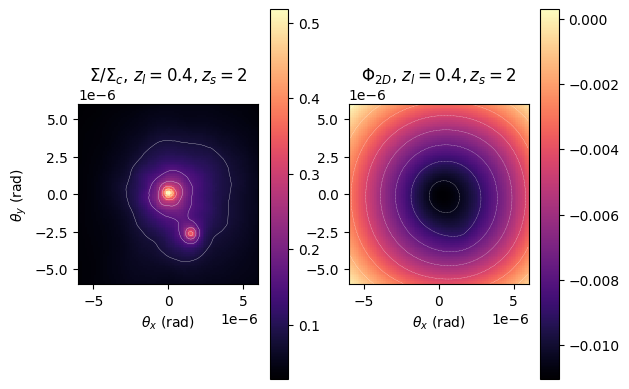

In [15]:
plt.subplot(1, 2, 1)
i = 1

z_l = 0.4
z_s = 2

theta = X[i, :]/D_angular(z_l)
Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
plt.pcolormesh(theta, theta, galaxies[i, :, :]/Sigma_c , cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, galaxies[i, :, :]/Sigma_c , colors = 'white', linewidths = 0.2)
plt.title('$\Sigma/\Sigma_c$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.ylabel('$\\theta_y$ (rad)')
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.pcolormesh(theta, theta, newtonian_potential_grid(theta, galaxies[i, :, :]), cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, newtonian_potential_grid(theta, galaxies[i, :, :]), colors = 'white', linewidths = 0.2)
plt.title('$\Phi_{2D}$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.gca().set_aspect('equal')


In [16]:
def lensing_potential_map(z_s, z_l, theta_grid, Sigma):
    dtheta = theta_grid[1] - theta_grid[0]
    Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
    eps = 0.0001*dtheta #softening length
    integrand = Sigma[:, :, None, None]*np.log(np.sqrt((theta_grid[:, None, None, None] - theta_grid[None, None, :, None])**2 + (theta_grid[None, :, None, None] - theta_grid[None, None, None, :])**2 + eps**2) )
    result = np.sum(integrand, axis = (0, 1))/np.pi
    return dtheta*dtheta*(result/Sigma_c)# - np.ones_like(result)*result[0, 0]/Sigma_c)

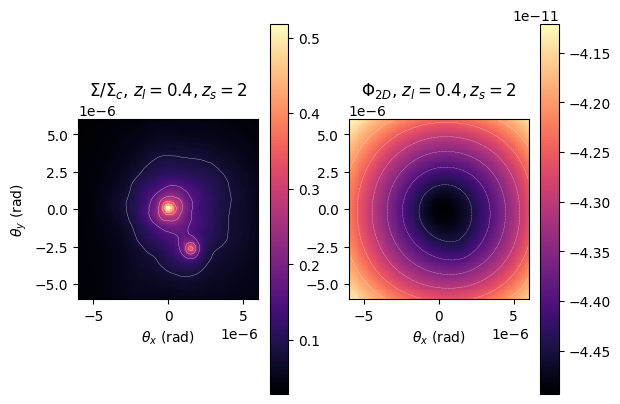

In [17]:
plt.subplot(1, 2, 1)
i = 1

z_l = 0.4
z_s = 2

theta = X[i, :]/D_angular(z_l)
Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
plt.pcolormesh(theta, theta, galaxies[i, :, :]/Sigma_c , cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, galaxies[i, :, :]/Sigma_c , colors = 'white', linewidths = 0.2)
plt.title('$\Sigma/\Sigma_c$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.ylabel('$\\theta_y$ (rad)')
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.pcolormesh(theta, theta, lensing_potential_map(z_s, z_l, theta, galaxies[i, :, :]), cmap = 'magma')
plt.colorbar()
plt.contour(theta, theta, lensing_potential_map(z_s, z_l, theta, galaxies[i, :, :]), colors = 'white', linewidths = 0.2)
plt.title('$\Phi_{2D}$, $z_l = $' + str(z_l) + '$, z_s = $' + str(z_s))
plt.xlabel('$\\theta_x$ (rad)')
plt.gca().set_aspect('equal')

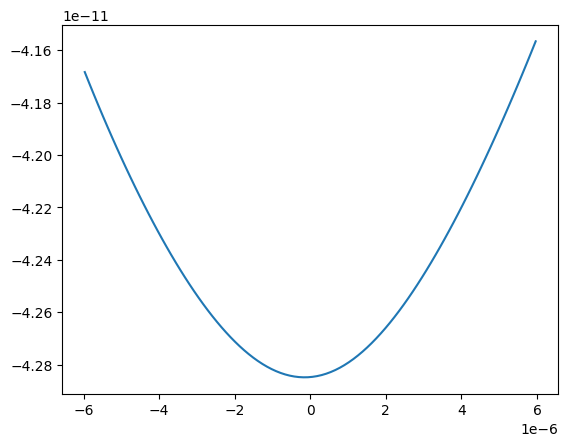

In [18]:
plt.plot(theta, lensing_potential_map(z_s, z_l, theta, galaxies[i, :, :])[:, 10])

In [19]:
def lensing_potential(theta_p, z_s, z_l, theta_grid, Sigma):
    dtheta = theta_grid[1] - theta_grid[0]
    Sigma_c = D_angular(z_s)/(4*np.pi*D_sl(z_s, z_l)*D_angular(z_l))/GM_c2
    eps = 0.0001*dtheta #softening length
    integrand = Sigma[:, :]*np.log(np.sqrt((theta_p[0]*np.ones_like(theta_grid[:, None]) - theta_grid[:, None])**2 + (theta_p[1]*np.ones_like(theta_grid[None, :]) - theta_grid[None, :])**2 + eps**2) )
    result = np.sum(integrand)/np.pi
    return dtheta*dtheta*(result/Sigma_c)# - np.ones_like(result)*result[0, 0]/Sigma_c)

In [20]:
theta_p = np.asarray([0.5, 0.1])
lensing_potential(theta_p, z_s, z_l, theta, galaxies[i, :, :])
print(galaxies[i, :, :])
def alpha(theta_p, z_s, z_l, theta_grid, Sigma):
    theta_x, theta_y = theta_p
    dtheta = 1*(theta_grid[1] - theta_grid[0])
    #x component
    theta_plus = np.asarray([theta_x + dtheta, theta_y])
    theta_min = np.asarray([theta_x - dtheta, theta_y])
    alpha_x = 0.5*(lensing_potential(theta_plus, z_s, z_l, theta_grid, Sigma) - lensing_potential(theta_min, z_s, z_l, theta_grid, Sigma))/dtheta
    
    #y component
    theta_plus = np.asarray([theta_x, theta_y + dtheta])
    theta_min = np.asarray([theta_x, theta_y - dtheta])
    alpha_y = 0.5*(lensing_potential(theta_plus, z_s, z_l, theta_grid, Sigma) - lensing_potential(theta_min, z_s, z_l, theta_grid, Sigma))/dtheta
    
    return alpha_x, alpha_y

[[32598470.2899084  32976481.99444893 33375154.15175674 ...
  42461165.37476303 42110410.40602139 41814389.92053877]
 [32620469.30407277 32987771.18127406 33311287.41347381 ...
  42989383.36788158 42670444.04578161 42295762.36634365]
 [32579700.83624496 32927012.89647245 33222622.09198541 ...
  43683689.18145633 43236759.06679604 42815315.02672582]
 ...
 [27960515.76914379 28179192.22123928 28419629.19808583 ...
  36256630.76967985 35846437.54214657 35519001.71166335]
 [27711356.22018791 27949781.9070903  28205769.93348292 ...
  36019185.08020227 35468224.60752785 35096261.39888125]
 [27492458.19360393 27723379.08834714 27948484.99761893 ...
  35693339.46955175 35096945.61419258 34618554.64923657]]


In [21]:
z_l = 0.18
z_s = 2
i = 0
theta_p = np.asarray([-1.348, 0.966])*4.8*1e-6
alpha_list = alpha(theta_p, z_s, z_l, X[i, :]/D_angular(z_l), galaxies[i, :, :])
type(alpha_list)
print(alpha_list)

(-7.918795287093007e-07, 4.5206496290805144e-07)


4.924769261357997e-06
1.6792463396471952e-06
1.6276872343692623e-06
1.5769171555265125e-06
1.5622375171423361e-06
1.4894739508812563e-06
1.4536906863053973e-06


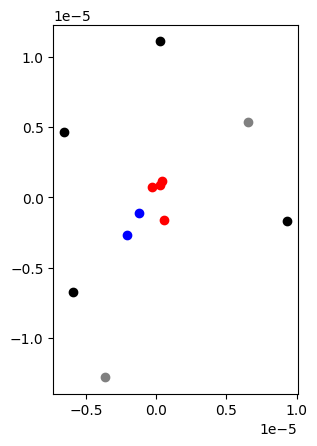

In [22]:
#Angles given as in paper (arcseconds)
A = np.array([-1.348, 0.966])
B = np.array([0.054, 2.293])
C = np.array([-1.227, -1.387])
D = np.array([1.915, -0.340])
E = np.array([-0.747, -2.644])
F = np.array([1.35, 1.11])

#listed all angles of the quasar images
theta_list = np.array([A, B, C, D, E, F])

#transform to radians (1 arcsec = 4.84814e-6 radians)
theta_list*= 4.84814e-6

#redshifts of the two intervening galaxies + of the sources
#NOTE: first galaxy/lens refers to first lens from the perspective of the quasar! So first galaxy/lens is the one further away from us with a higher redshift
z_l_1= 0.184 #this is redshift of second galaxy (i.e. second lens)
z_l_2 = 1.885  #this is redshift of first galaxy (i.e first lens) NOTE: This is now also the redshift of the first source (next line)
z_s_1 = 1.885 #this is the second galaxy, for the first lensing
#z_s_2 = TODO: what's the redshift of the quasar?


def calc_deviation_from_merge(theta_p, z_s_1, z_l_1, theta_grid, Sigma):
    
    alpha_list = np.empty(shape=(6, 2))

    for i in np.arange(0, 6):
        #print(theta_p[i])
        alpha_list[i, 0], alpha_list[i, 1] = alpha(theta_p[i], z_s, z_l, theta_grid, Sigma)

    #Generate beta values
    beta_list = theta_p - alpha_list

    #A, B, C and D should have roughly the same beta (i.e. source location after first lensing(from our perspective first))
    beta_list_ABCD = beta_list[:4]
    beta_list_EF = beta_list[4:]

    sum_abs_beta_list_ABCD = np.std(beta_list_ABCD) #need to take the difference
    sum_abs_beta_list_EF = np.std(beta_list_EF)
    
    total_sum = sum_abs_beta_list_ABCD + sum_abs_beta_list_EF
    return total_sum, beta_list

best_case = 100
for i, galaxy in enumerate(galaxies):
    total_sum = 100
    for phi in np.linspace(0, 2*np.pi, 100):
        R_phi = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
        theta_new =  np.dot(theta_list, R_phi.T)

        #plt.scatter(theta_new[:, 0], theta_new[:, 1], c='r')
        std_dev, beta_check = calc_deviation_from_merge(theta_new, z_s, z_l, X[i, :]/D_angular(z_l), galaxy*15)
        #plt.plot(beta_check[:, 0], beta_check)

        if (total_sum > std_dev):
            total_sum =  std_dev
            beta_best = beta_check
            theta_best = theta_new
    if best_case > total_sum:
        best_case = total_sum
        beta_best_case = beta_best
        theta_best_case = theta_best
        print(best_case)
    if total_sum < 1e-6:
        print("found one")
        #plt.scatter(beta_best[:4, 0], beta_best[:4, 1], c='r', label='beta best')
        #plt.scatter(beta_best[4:, 0], beta_best[4:, 1], c='b', label='beta best')
        break
    if i == 100:
        plt.scatter(beta_best_case[:4, 0], beta_best_case[:4, 1], c='r', label='beta best')
        plt.scatter(beta_best_case[4:, 0], beta_best_case[4:, 1], c='b', label='beta best')
        break


plt.gca().set_aspect('equal')

#plt.scatter(theta_best_case[:4, 0], theta_best_case[:4, 1], c='g', label='theta')
#plt.scatter(theta_best_case[4:, 0], theta_best_case[4:, 1], c='orange', label='theta')
plt.scatter(theta_list[:4, 0], theta_list[:4, 1], c='black', label='original theta')
plt.scatter(theta_list[4:, 0], theta_list[4:, 1], c='grey', label='original theta')

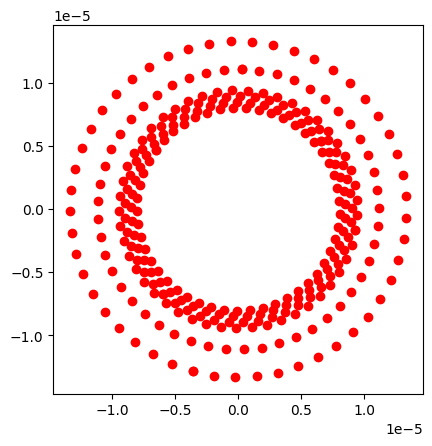

In [23]:
plt.gca().set_aspect('equal')

for phi in np.linspace(0, 2*np.pi, 50):
        R_phi = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
        theta_new =  np.dot(theta_list, R_phi.T)
        plt.scatter(theta_new[:, 0], theta_new[:, 1], c='r')
